# LRP Loss Eperiment 2

In [1]:
%%capture 
%run "./shared.ipynb"

In [2]:
from python.shared.model_keras import initialize_brats_model, initialize_slicenet_model_2
from python.explanation_guided_training.train_lrp_loss import train, get_lrp_loss, threshold_to_one, analysis_to_segmentation
from python.shared.mask_utils import mask_value, get_mask_stat, get_mask_of_seg_rgb, get_mask_of_brain, get_mask_of_seg
from python.shared.data_utils import LggHggGenerator
from python.shared.visualization import plot_rgb, plot_gray, plot_lrp

In [3]:
from tensorflow import keras
import json

In [4]:
batch_size = 16
epochs = 15
IMG_HEIGHT = 240
IMG_WIDTH = 240

## Data loading

In [5]:
train_dir = '../data/train/confidence_19/'
seg_train_dir = '../data/train/seg_confidence_19/'
val_dir = '../data/valid/confidence_19/'
seg_val_dir = '../data/valid/seg_confidence_19/'
test_dir = '../data/test/confidence_19/'
seg_test_dir = '../data/test/seg_confidence_19/'

train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
train_seg_generator = ImageDataGenerator(rotation_range=45,
                                           horizontal_flip=True,
                                           vertical_flip=True)
val_image_generator = ImageDataGenerator(rescale=1./255)
val_seg_generator = ImageDataGenerator()

lgg_hgg_generator = LggHggGenerator(train_image_generator, train_seg_generator, train_dir, seg_train_dir)
val_lgg_hgg_generator = LggHggGenerator(val_image_generator, val_seg_generator, val_dir, seg_val_dir)
test_lgg_hgg_generator = LggHggGenerator(val_image_generator, val_seg_generator, test_dir, seg_test_dir)

In [6]:
train_image_gen = lgg_hgg_generator.get_image_generator(batch_size, True)
train_seg_gen = lgg_hgg_generator.get_seg_generator(batch_size, True)
val_image_gen = val_lgg_hgg_generator.get_image_generator(batch_size)
val_seg_gen = val_lgg_hgg_generator.get_seg_generator(batch_size)
test_image_gen = test_lgg_hgg_generator.get_image_generator(batch_size, True)
test_seg_gen = test_lgg_hgg_generator.get_seg_generator(batch_size, True)

Found 1645 images belonging to 2 classes.
Found 1645 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 446 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.


In [7]:
def evaluate_model(model, val_image_gen, val_seg_gen):
    m, p, y = get_mask_stat(val_image_gen, val_seg_gen, model)
    print("LGG: ", np.mean(m[y==0]), "HGG:", np.mean(m[y==1]))
    
    y_true_v = []
    pred_v = []
    iterations = val_image_gen.samples / batch_size
    for i, (images, labels) in enumerate(val_image_gen):
        prob = model.predict(images)
        p = prob.argmax(axis=1)
        pred_v.extend(p)
        y_true_v.extend(labels)
        if i + 1 > iterations:
            break
    visualization.plot_model_performance(y_true_v, pred_v)

def postprocess_lrp(analyzed_image):
    analyzed_image = analyzed_image.sum(axis=np.argmax(np.asarray(analyzed_image.shape) == 3))
    analyzed_image /= np.max(np.abs(analyzed_image))
    return analyzed_image

def show_analysis(image, seg, y, model, analyzer):
    a = analyzer.analyze(np.array([image]))
    a = a['input_layer'][0]
    prob = model.predict(np.array([image]))
    pred = prob.argmax(axis=1)[0]
    mask_v = mask_value(a, image, get_mask_of_seg_rgb(seg))
    print("Mask Value: ", mask_v)
    print("Label: ", int(y), "Pred: ", pred)
    print("Probes: ", prob[0])
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()
    plot_lrp(a, ax=axes[0], title = "{:.3f}".format(mask_v))
    plot_rgb(image, ax=axes[1])
    plot_gray(seg, ax=axes[2])
    
def save_logs(name, data):
    data['name'] = name
    json.dump( data, open( name + ".json", 'w' ) )

### Data

In [8]:
x, y = next(val_image_gen)
x_seg, y_seg = next(val_seg_gen)

(16, 240, 240, 3)


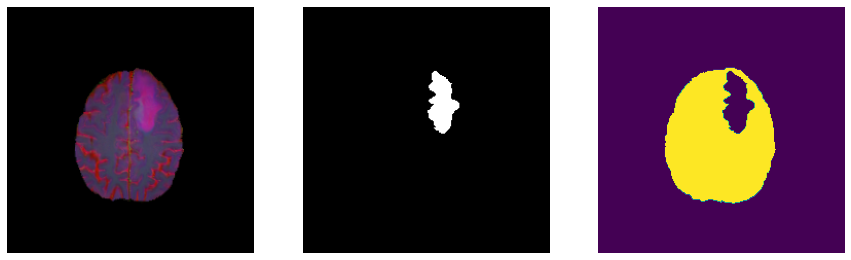

In [9]:
print(x.shape)
i = 11
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()
plot_rgb(x[i], ax= axes[0])
plot_gray(threshold_to_one(x_seg[i]), ax= axes[1])
plot_rgb(get_mask_of_brain(x[i], get_mask_of_seg(x_seg[i]).squeeze()), ax= axes[2])

## Model definition

In [8]:
model = initialize_slicenet_model_2(IMG_HEIGHT, IMG_WIDTH)
optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.8)
analyzer = innvestigate.create_analyzer("lrp.sequential_preset_b", model, epsilon=1)
loss_function = get_lrp_loss(analyzer)

/usr/local/lib/python3.6/dist-packages/innvestigate/analyzer/relevance_based/relevance_analyzer.py:557: DeprecationWarning: LRPSequentialPresetB is deprecated. Use LRPSequentialCompositeB instead
  DeprecationWarning)


In [9]:
images, y = next(test_image_gen)
images_seg, y_seg = next(test_seg_gen)

## Model training

Epoch: 0, Train loss: 4.001, Train orgloss: 0.694,Train mask: 0.190, Train accuracy: 0.545
          Test loss: 3.094, Test org loss: 0.682, Test mask: 0.237, Test accuracy: 0.563


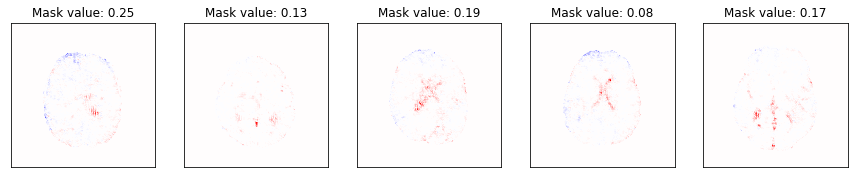

Epoch: 1, Train loss: 2.040, Train orgloss: 0.659,Train mask: 0.368, Train accuracy: 0.618
          Test loss: 1.145, Test org loss: 0.623, Test mask: 0.582, Test accuracy: 0.646


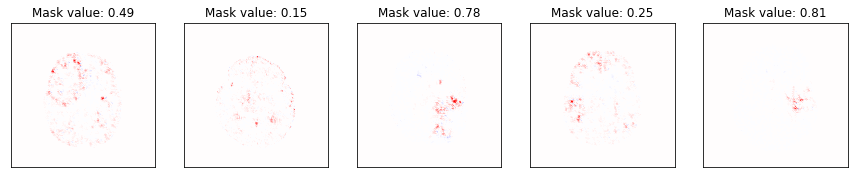

Epoch: 2, Train loss: 1.174, Train orgloss: 0.569,Train mask: 0.492, Train accuracy: 0.726
          Test loss: 1.200, Test org loss: 0.601, Test mask: 0.525, Test accuracy: 0.700


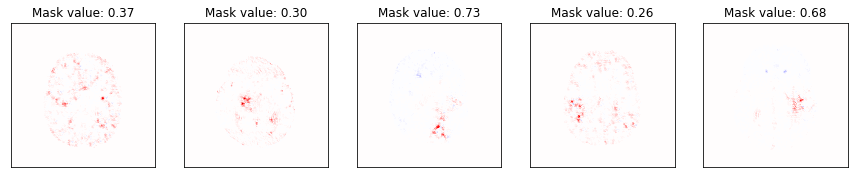

Epoch: 3, Train loss: 1.241, Train orgloss: 0.533,Train mask: 0.439, Train accuracy: 0.742
          Test loss: 1.072, Test org loss: 0.565, Test mask: 0.587, Test accuracy: 0.700


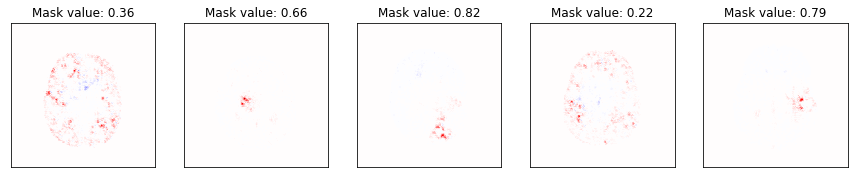

Epoch: 4, Train loss: 1.021, Train orgloss: 0.481,Train mask: 0.480, Train accuracy: 0.791
          Test loss: 1.160, Test org loss: 0.562, Test mask: 0.519, Test accuracy: 0.753


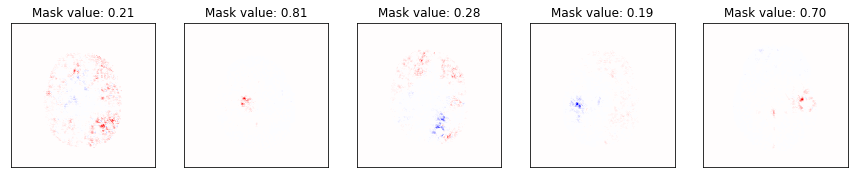

Epoch: 5, Train loss: 0.931, Train orgloss: 0.406,Train mask: 0.450, Train accuracy: 0.852
          Test loss: 0.883, Test org loss: 0.439, Test mask: 0.528, Test accuracy: 0.814


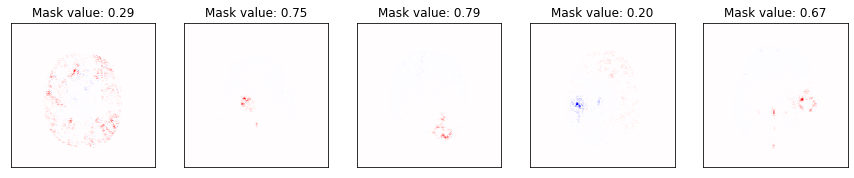

Epoch: 6, Train loss: 0.875, Train orgloss: 0.371,Train mask: 0.434, Train accuracy: 0.872
          Test loss: 0.823, Test org loss: 0.404, Test mask: 0.507, Test accuracy: 0.825


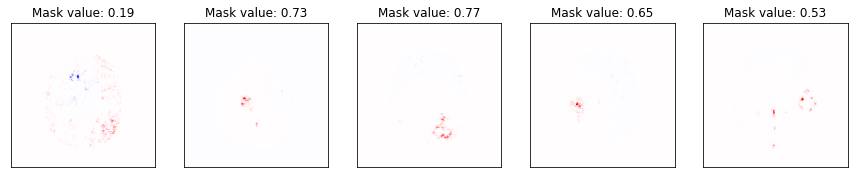

Epoch: 7, Train loss: 0.839, Train orgloss: 0.341,Train mask: 0.417, Train accuracy: 0.891
          Test loss: 0.840, Test org loss: 0.489, Test mask: 0.598, Test accuracy: 0.785


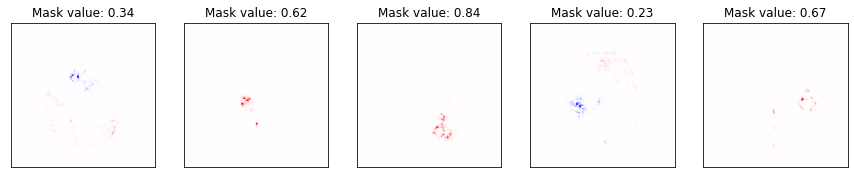

Epoch: 8, Train loss: 0.686, Train orgloss: 0.291,Train mask: 0.426, Train accuracy: 0.913
          Test loss: 0.831, Test org loss: 0.421, Test mask: 0.476, Test accuracy: 0.850


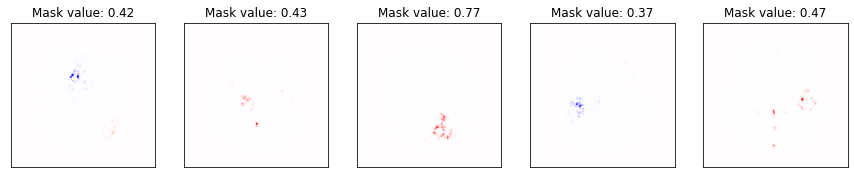

Epoch: 9, Train loss: 0.719, Train orgloss: 0.278,Train mask: 0.409, Train accuracy: 0.914
          Test loss: 0.762, Test org loss: 0.352, Test mask: 0.427, Test accuracy: 0.854


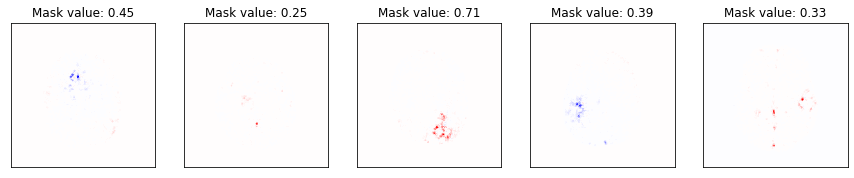

Epoch: 10, Train loss: 0.662, Train orgloss: 0.262,Train mask: 0.406, Train accuracy: 0.919
          Test loss: 0.962, Test org loss: 0.533, Test mask: 0.503, Test accuracy: 0.825


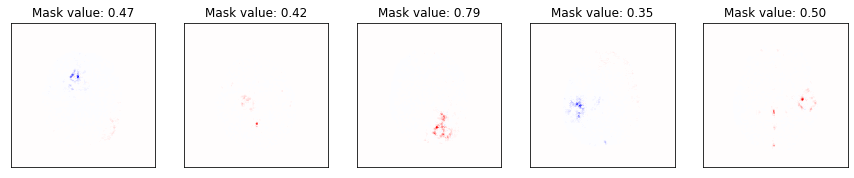

Epoch: 11, Train loss: 0.688, Train orgloss: 0.270,Train mask: 0.412, Train accuracy: 0.913
          Test loss: 0.698, Test org loss: 0.342, Test mask: 0.461, Test accuracy: 0.845


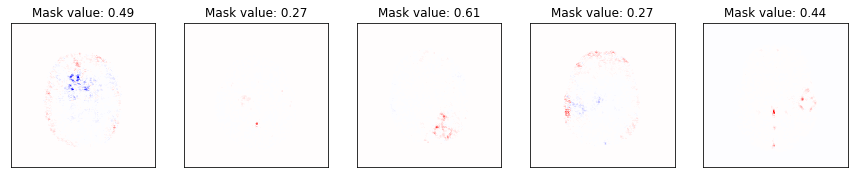

Epoch: 12, Train loss: 0.684, Train orgloss: 0.273,Train mask: 0.406, Train accuracy: 0.916
          Test loss: 1.126, Test org loss: 0.468, Test mask: 0.437, Test accuracy: 0.845


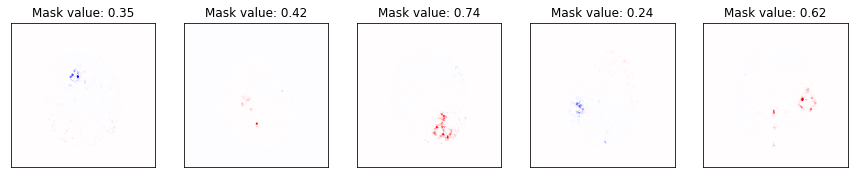

Epoch: 13, Train loss: 0.618, Train orgloss: 0.232,Train mask: 0.388, Train accuracy: 0.937
          Test loss: 1.231, Test org loss: 0.595, Test mask: 0.433, Test accuracy: 0.816


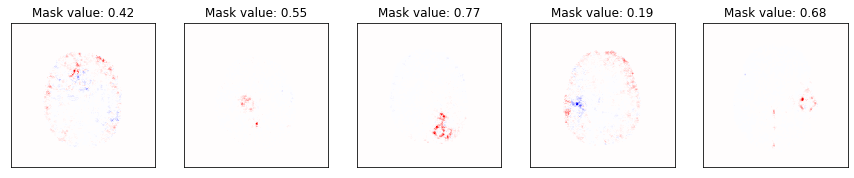

Epoch: 14, Train loss: 0.576, Train orgloss: 0.216,Train mask: 0.391, Train accuracy: 0.938
          Test loss: 1.339, Test org loss: 0.684, Test mask: 0.446, Test accuracy: 0.827


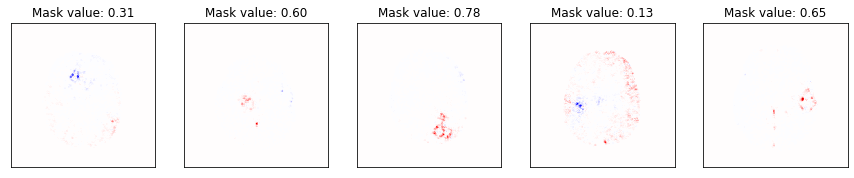

Epoch: 15, Train loss: 0.626, Train orgloss: 0.231,Train mask: 0.383, Train accuracy: 0.939
          Test loss: 1.076, Test org loss: 0.522, Test mask: 0.452, Test accuracy: 0.868


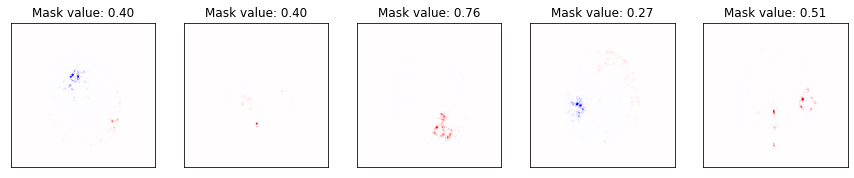

Epoch: 16, Train loss: 0.694, Train orgloss: 0.245,Train mask: 0.394, Train accuracy: 0.926
          Test loss: 1.201, Test org loss: 0.636, Test mask: 0.537, Test accuracy: 0.832


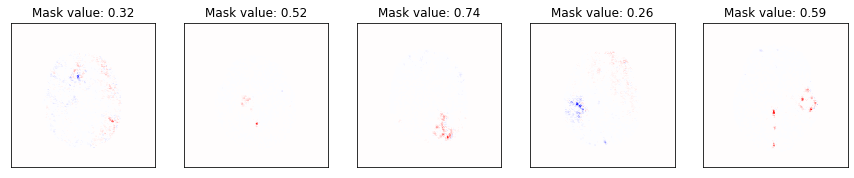

Epoch: 17, Train loss: 0.531, Train orgloss: 0.207,Train mask: 0.412, Train accuracy: 0.940
          Test loss: 1.318, Test org loss: 0.432, Test mask: 0.377, Test accuracy: 0.836


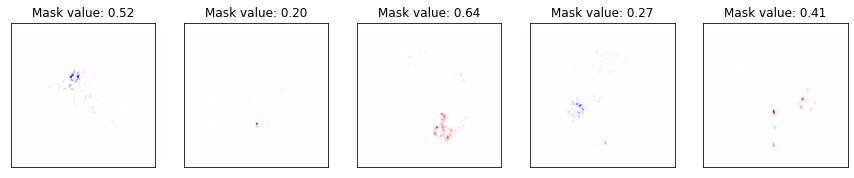

Epoch: 18, Train loss: 0.470, Train orgloss: 0.175,Train mask: 0.385, Train accuracy: 0.957
          Test loss: 1.221, Test org loss: 0.576, Test mask: 0.427, Test accuracy: 0.843


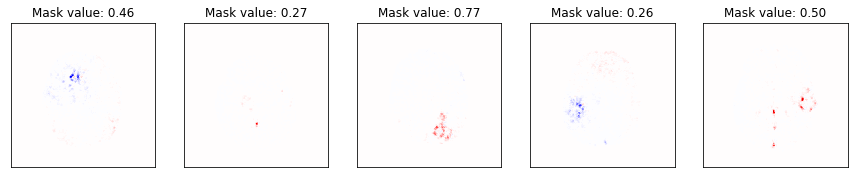

Epoch: 19, Train loss: 0.571, Train orgloss: 0.207,Train mask: 0.375, Train accuracy: 0.942
          Test loss: 1.345, Test org loss: 0.688, Test mask: 0.480, Test accuracy: 0.814


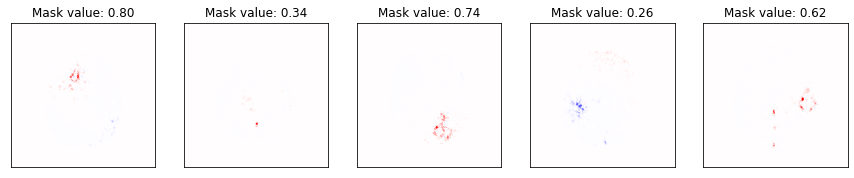

In [12]:
# Penalization 1
train_results = train(model, 
                      train_image_gen, 
                      train_seg_gen, 
                      val_image_gen, 
                      val_seg_gen,
                      loss_function,
                      optimizer,
                      epochs, 
                      batch_size,
                      analyzer,
                      images,
                      images_seg)

Epoch: 0, Train loss: 0.680, Train orgloss: 0.680,Train mask: 0.247, Train accuracy: 0.574
          Test loss: 0.658, Test org loss: 0.658, Test mask: 0.341, Test accuracy: 0.639


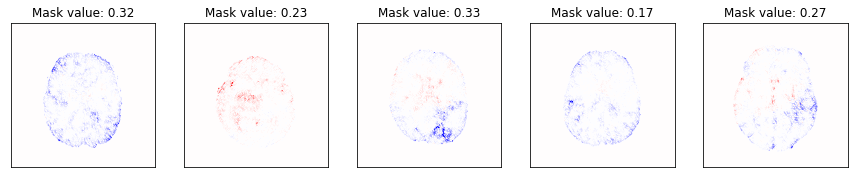

Epoch: 1, Train loss: 0.623, Train orgloss: 0.623,Train mask: 0.332, Train accuracy: 0.676
          Test loss: 0.624, Test org loss: 0.624, Test mask: 0.408, Test accuracy: 0.661


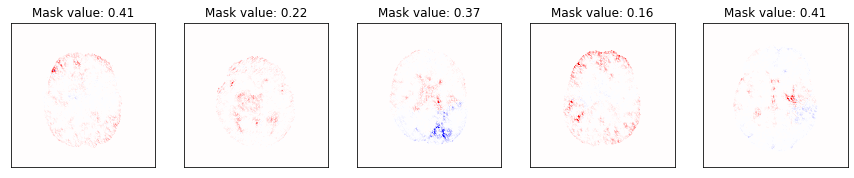

Epoch: 2, Train loss: 0.557, Train orgloss: 0.557,Train mask: 0.361, Train accuracy: 0.732
          Test loss: 0.712, Test org loss: 0.712, Test mask: 0.425, Test accuracy: 0.626


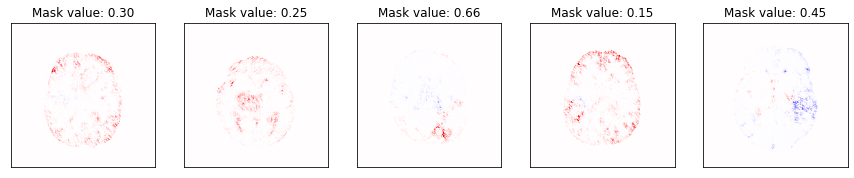

Epoch: 3, Train loss: 0.551, Train orgloss: 0.551,Train mask: 0.340, Train accuracy: 0.721
          Test loss: 0.564, Test org loss: 0.564, Test mask: 0.398, Test accuracy: 0.641


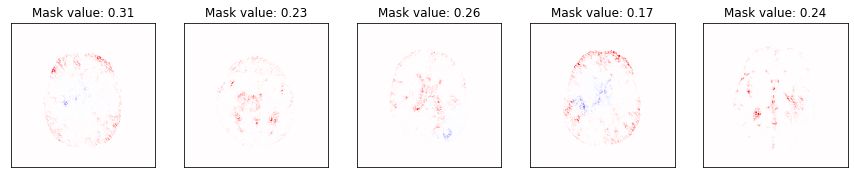

Epoch: 4, Train loss: 0.524, Train orgloss: 0.524,Train mask: 0.346, Train accuracy: 0.751
          Test loss: 0.562, Test org loss: 0.562, Test mask: 0.426, Test accuracy: 0.702


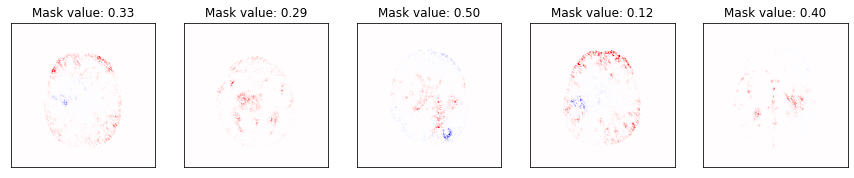

Epoch: 5, Train loss: 0.495, Train orgloss: 0.495,Train mask: 0.343, Train accuracy: 0.769
          Test loss: 0.554, Test org loss: 0.554, Test mask: 0.398, Test accuracy: 0.726


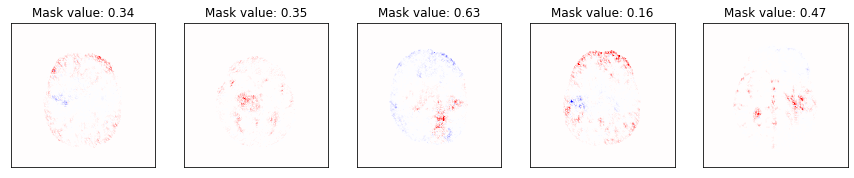

Epoch: 6, Train loss: 0.465, Train orgloss: 0.465,Train mask: 0.353, Train accuracy: 0.794
          Test loss: 0.491, Test org loss: 0.491, Test mask: 0.376, Test accuracy: 0.713


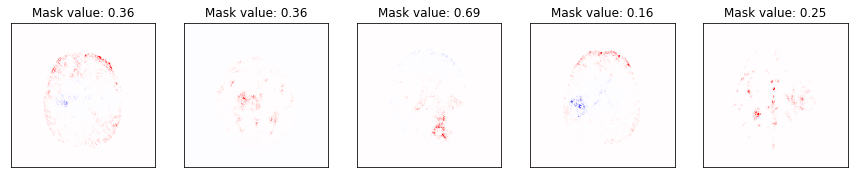

Epoch: 7, Train loss: 0.416, Train orgloss: 0.416,Train mask: 0.357, Train accuracy: 0.835
          Test loss: 0.467, Test org loss: 0.467, Test mask: 0.522, Test accuracy: 0.747


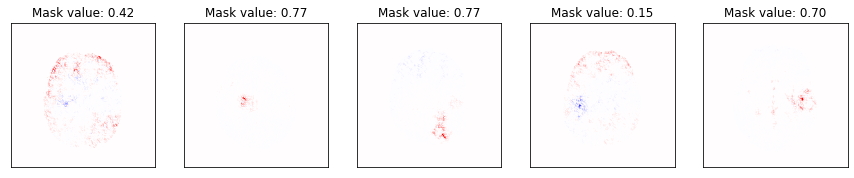

Epoch: 8, Train loss: 0.373, Train orgloss: 0.373,Train mask: 0.391, Train accuracy: 0.863
          Test loss: 0.387, Test org loss: 0.387, Test mask: 0.400, Test accuracy: 0.825


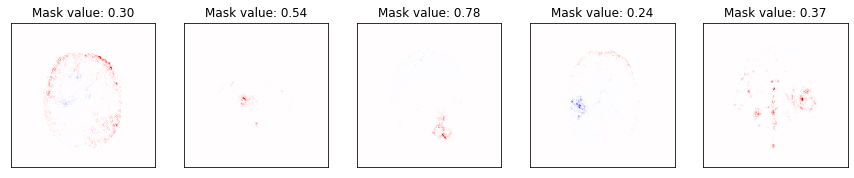

Epoch: 9, Train loss: 0.323, Train orgloss: 0.323,Train mask: 0.370, Train accuracy: 0.897
          Test loss: 0.409, Test org loss: 0.409, Test mask: 0.436, Test accuracy: 0.814


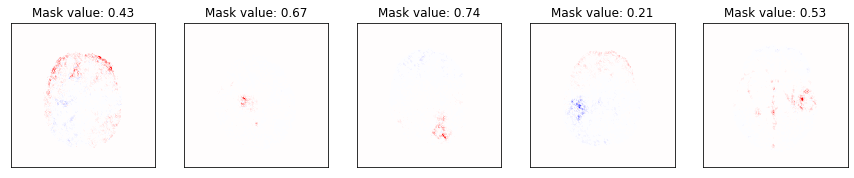

Epoch: 10, Train loss: 0.329, Train orgloss: 0.329,Train mask: 0.376, Train accuracy: 0.891
          Test loss: 0.362, Test org loss: 0.362, Test mask: 0.432, Test accuracy: 0.857


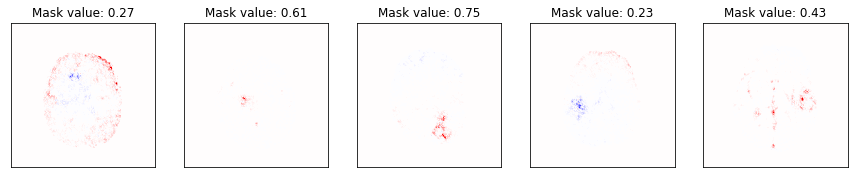

Epoch: 11, Train loss: 0.294, Train orgloss: 0.294,Train mask: 0.374, Train accuracy: 0.905
          Test loss: 0.389, Test org loss: 0.389, Test mask: 0.393, Test accuracy: 0.807


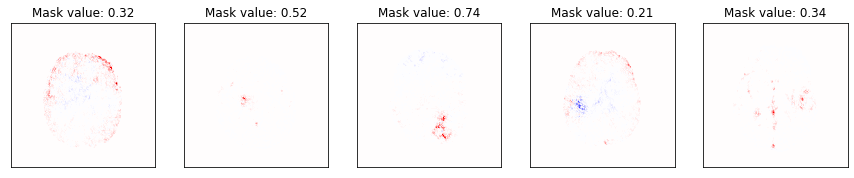

Epoch: 12, Train loss: 0.271, Train orgloss: 0.271,Train mask: 0.360, Train accuracy: 0.909
          Test loss: 0.360, Test org loss: 0.360, Test mask: 0.405, Test accuracy: 0.861


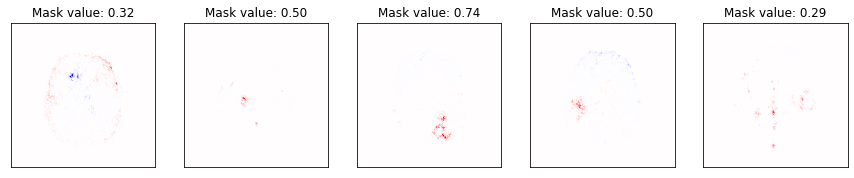

Epoch: 13, Train loss: 0.251, Train orgloss: 0.251,Train mask: 0.353, Train accuracy: 0.923
          Test loss: 0.558, Test org loss: 0.558, Test mask: 0.363, Test accuracy: 0.809


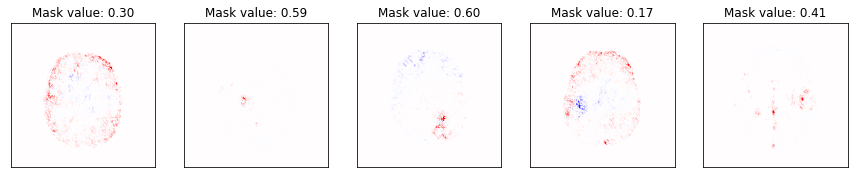

Epoch: 14, Train loss: 0.243, Train orgloss: 0.243,Train mask: 0.349, Train accuracy: 0.923
          Test loss: 0.440, Test org loss: 0.440, Test mask: 0.346, Test accuracy: 0.863


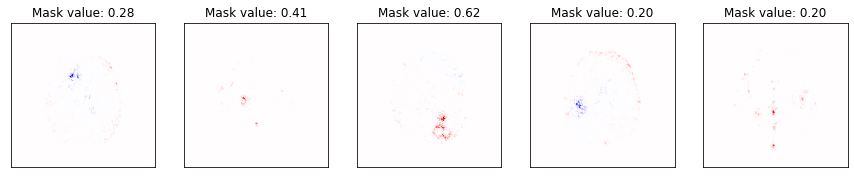

Epoch: 15, Train loss: 0.225, Train orgloss: 0.225,Train mask: 0.339, Train accuracy: 0.927
          Test loss: 0.385, Test org loss: 0.385, Test mask: 0.406, Test accuracy: 0.859


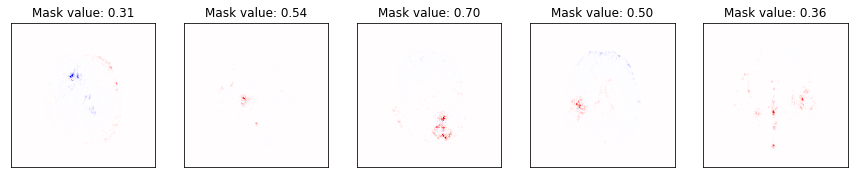

Epoch: 16, Train loss: 0.192, Train orgloss: 0.192,Train mask: 0.333, Train accuracy: 0.941
          Test loss: 0.459, Test org loss: 0.459, Test mask: 0.418, Test accuracy: 0.863


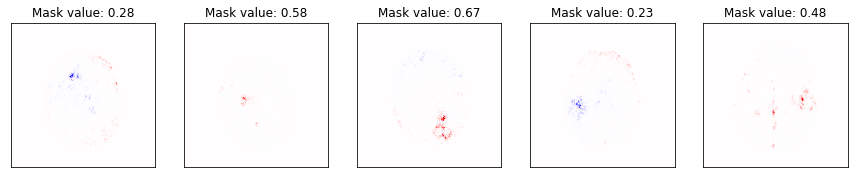

Epoch: 17, Train loss: 0.178, Train orgloss: 0.178,Train mask: 0.334, Train accuracy: 0.946
          Test loss: 0.330, Test org loss: 0.330, Test mask: 0.347, Test accuracy: 0.863


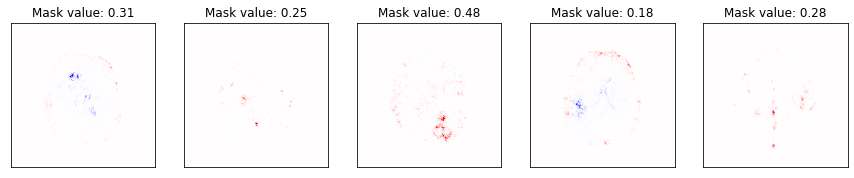

Epoch: 18, Train loss: 0.202, Train orgloss: 0.202,Train mask: 0.353, Train accuracy: 0.940
          Test loss: 0.537, Test org loss: 0.537, Test mask: 0.395, Test accuracy: 0.818


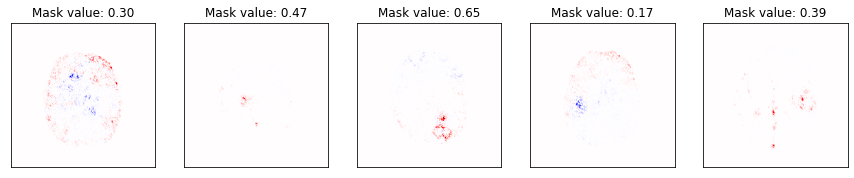

Epoch: 19, Train loss: 0.215, Train orgloss: 0.215,Train mask: 0.347, Train accuracy: 0.938
          Test loss: 0.591, Test org loss: 0.591, Test mask: 0.446, Test accuracy: 0.787


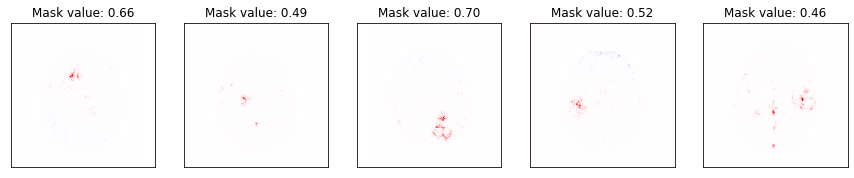

In [12]:
# Original model
train_results = train(model, 
                      train_image_gen, 
                      train_seg_gen, 
                      val_image_gen, 
                      val_seg_gen,
                      loss_function,
                      optimizer,
                      epochs, 
                      batch_size,
                      analyzer,
                      images,
                      images_seg)

In [11]:
model.save('../models/model-04-5-pen1_5.h5')

### Evaluate single model

In [11]:
save_logs(
    'data-04-5-pen1_3',
    train_results
)

In [12]:
data_org = json.load( open( "data-04-5-org.json" ))
data_pen1 = json.load( open( "data-04-5-pen1.json" ))
data_pen15 = json.load( open( "data-04-5-pen1_3.json" ))

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
LGG:  0.38632888 HGG: 0.7394278
Model performance:
              precision    recall  f1-score   support

         LGG       0.91      0.72      0.80       116
         HGG       0.79      0.94      0.86       130

    accuracy                           0.83       246
   macro avg       0.85      0.83      0.83       246
weighted avg       0.85      0.83      0.83       246



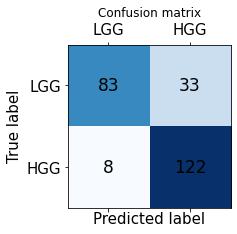

In [15]:
evaluate_model(model, test_lgg_hgg_generator.get_image_generator(batch_size), test_lgg_hgg_generator.get_seg_generator(batch_size))

### Evaluate training iterations 

In [16]:
def plot_train_epoch(ax, data, metric_name, title, labels):
    colors = ['skyblue', 'lightcoral', 'indianred']
    for i, d in enumerate(data):
#         ax.plot( list(range(1, len(d['train_' + metric_name]) + 1)), 
#                 d['train_' + metric_name], color=colors[i], linewidth=2, label = "Train " + labels[i])
        ax.plot( list(range(1, len(d['train_' + metric_name]) + 1)), 
                d['test_' + metric_name], color=colors[i], linewidth=2, linestyle="--", label = "Test " + labels[i])
    ax.set_title(title)
    ax.legend()
    

In [11]:
data_org = json.load( open( "data-04-5-org.json" ))
data_pen1 = json.load( open( "data-04-5-pen1.json" ))
data_pen15 = json.load( open( "data-04-5-pen1_3.json" ))
data = [data_org, data_pen1]

In [13]:
plt.rcParams.update({'font.size': 15})

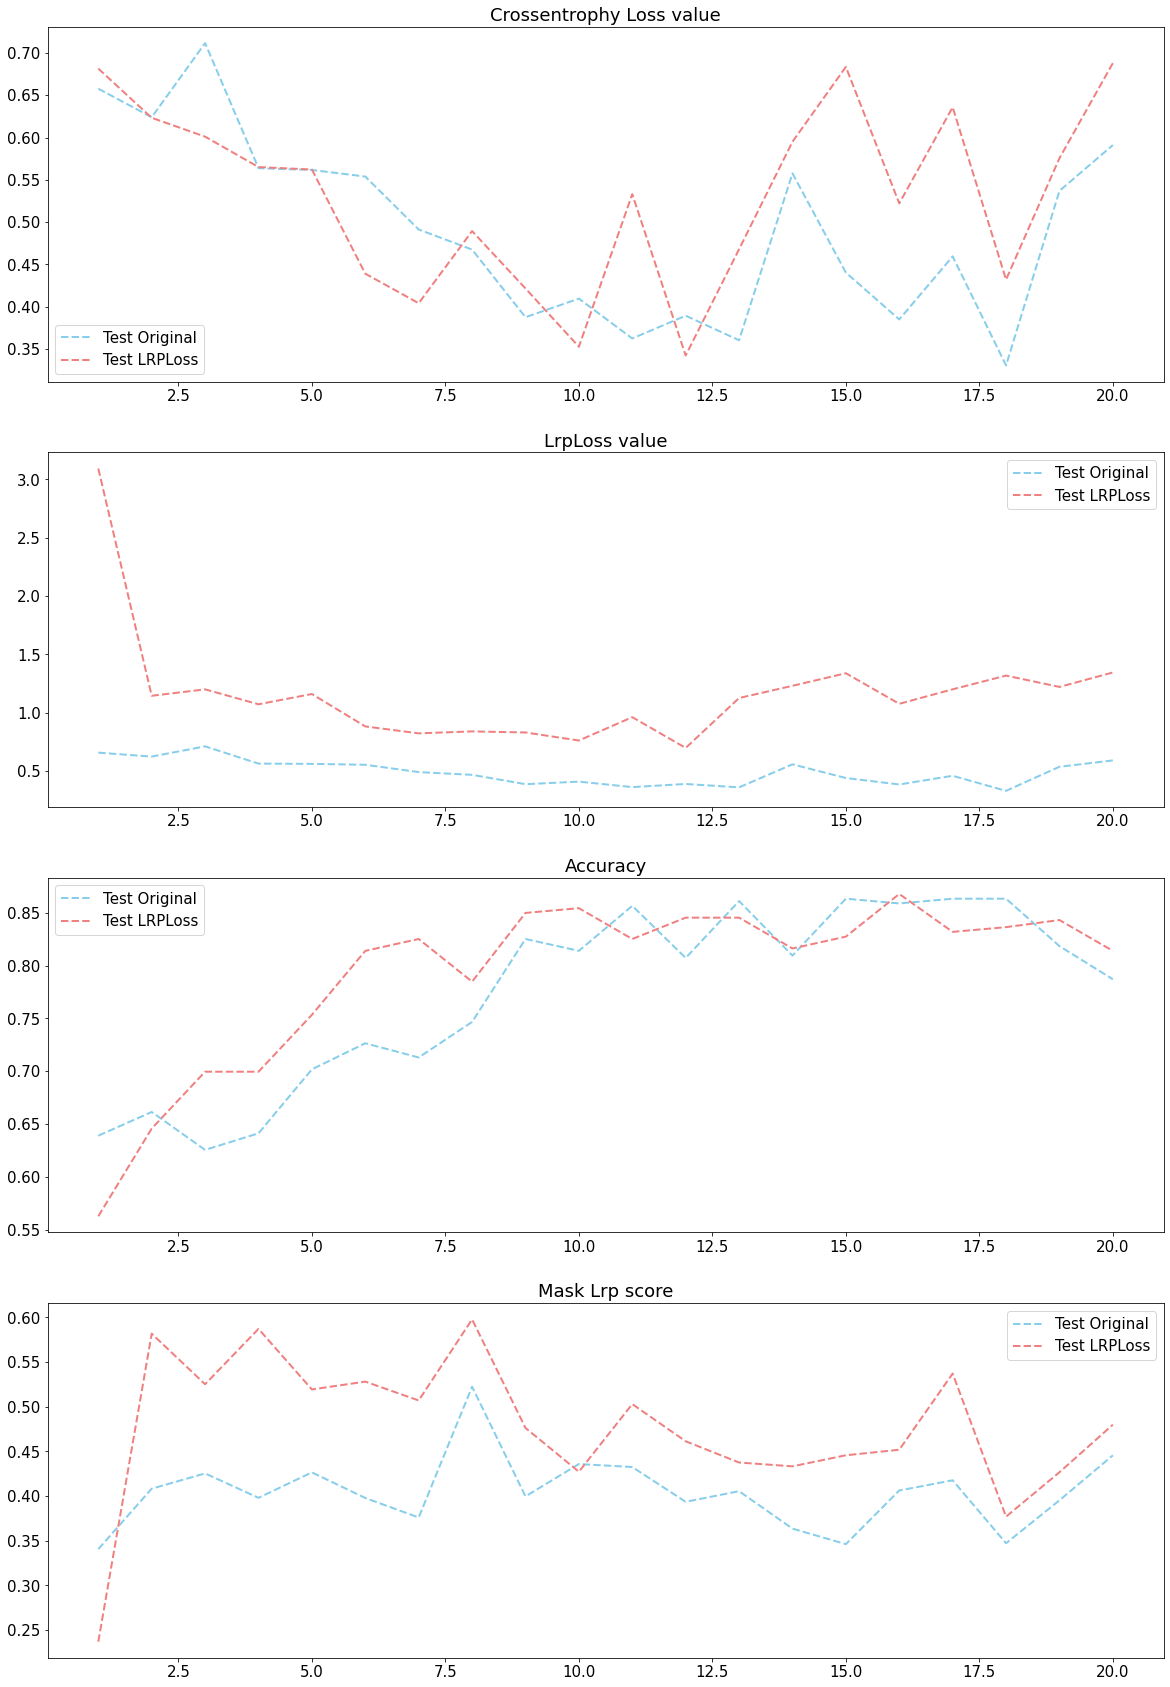

In [22]:
fig, axs = plt.subplots(4,1, figsize=(20,30))
axs = axs.flat
metrics_names = ['org_loss_values', 'loss_values', 'accuracy_values', 'mask_values']
titles = ['Crossentrophy Loss value', 'LrpLoss value', 'Accuracy', 'Mask Lrp score']
labels = ['Original', 'LRPLoss', 'Pen 1.5']
for i in range(4):
    plot_train_epoch(axs[i], data, metrics_names[i], titles[i], labels)

plt.show()

Mask Value:  0.61150336
Label:  1 Pred:  1
Probes:  [-2.5840764  9.126668 ]


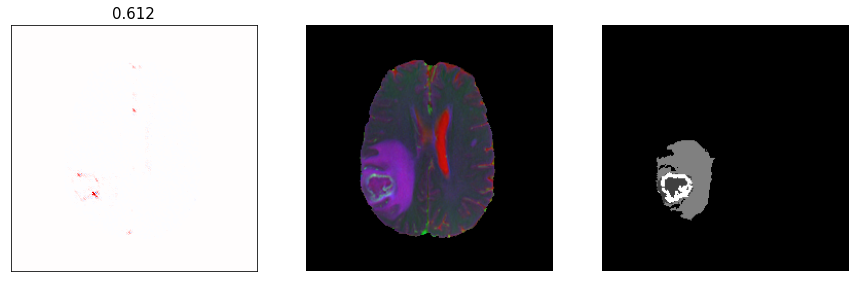

Mask Value:  0.05903581
Label:  1 Pred:  1
Probes:  [-1.8119328  3.6101718]


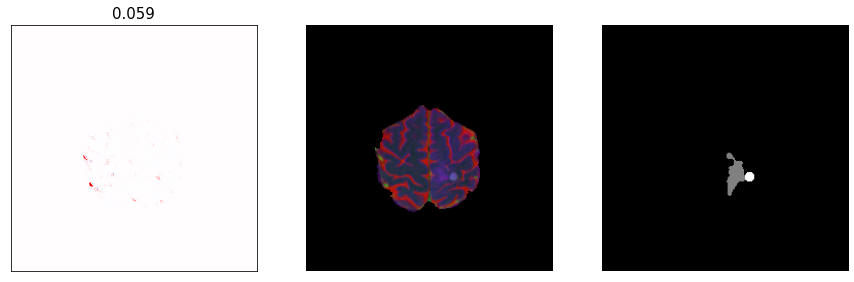

Mask Value:  0.11165205
Label:  0 Pred:  0
Probes:  [ 0.64383966 -0.6151488 ]


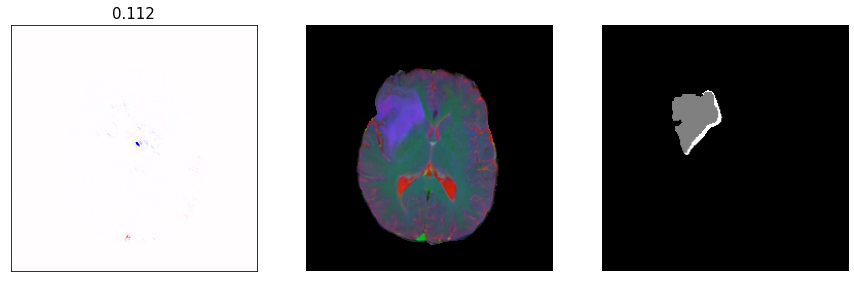

Mask Value:  0.17998268
Label:  0 Pred:  1
Probes:  [0.19415224 0.49102134]


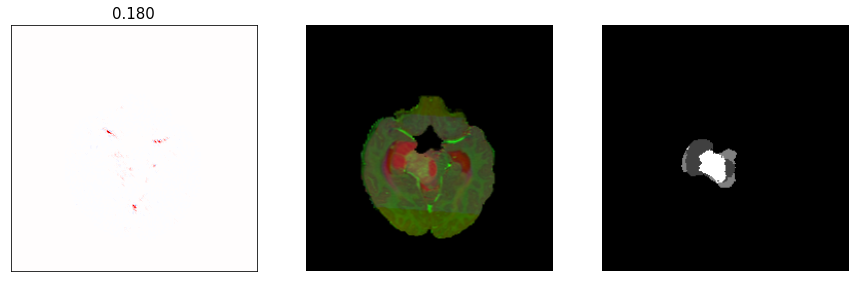

Mask Value:  0.4415802
Label:  1 Pred:  0
Probes:  [0.410003   0.37783164]


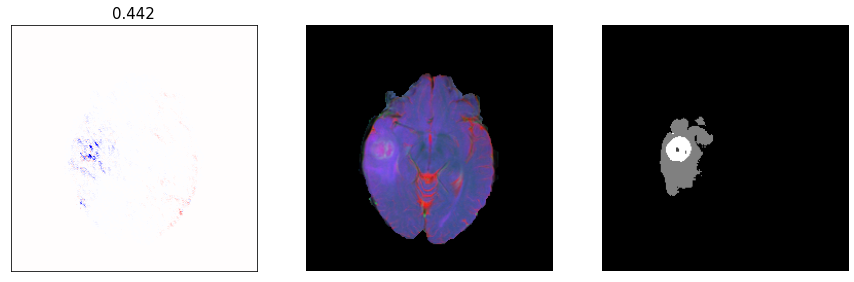

In [22]:
for i in range(5, 10):
    show_analysis(images[i], images_seg[i], y[i], model, analyzer)
    plt.show()

In [16]:
analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=1)

In [34]:
analyzer2 = innvestigate.create_analyzer("lrp.epsilon", model2, epsilon=1)
analyzer3 = innvestigate.create_analyzer("lrp.epsilon", model3, epsilon=1)

In [17]:
images, y = next(test_image_gen)
images_seg, y_seg = next(test_seg_gen)

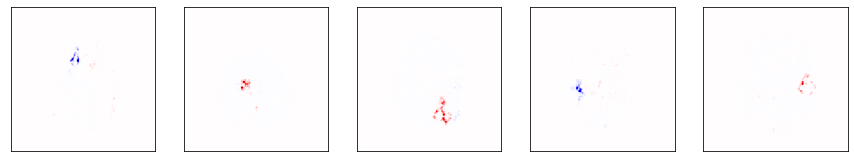

In [12]:
a = analyzer.analyze(images)['input_layer']
fig, axs = plt.subplots(1,5,figsize=(15, 20))
for x in range(5):
    visualization.plot_lrp(a[x], axs[x])

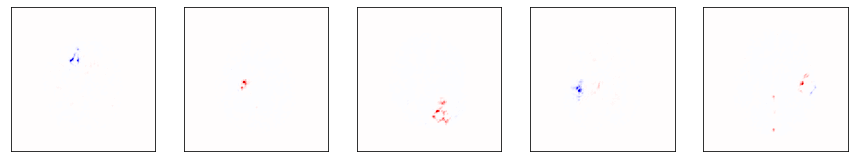

In [35]:
a = analyzer.analyze(images)['input_layer']
fig, axs = plt.subplots(1,5,figsize=(15, 20))
for x in range(5):
    visualization.plot_lrp(a[x], axs[x])


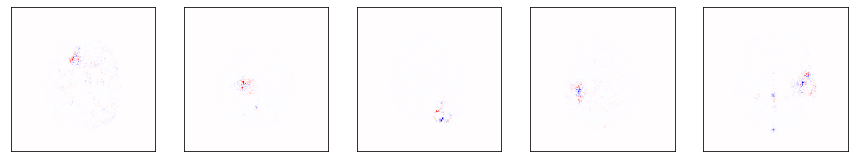

In [36]:
a = analyzer2.analyze(images)['input_layer']
fig, axs = plt.subplots(1,5,figsize=(15, 20))
for x in range(5):
    visualization.plot_lrp(a[x], axs[x])

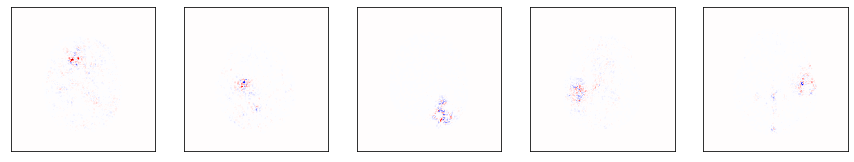

In [37]:
a = analyzer3.analyze(images)['input_layer']
fig, axs = plt.subplots(1,5,figsize=(15, 20))
for x in range(5):
    visualization.plot_lrp(a[x], axs[x])

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
LGG:  0.35524914 HGG: 0.75931305
Model performance:
              precision    recall  f1-score   support

         LGG       0.95      0.78      0.86       116
         HGG       0.83      0.96      0.89       130

    accuracy                           0.88       246
   macro avg       0.89      0.87      0.88       246
weighted avg       0.89      0.88      0.88       246



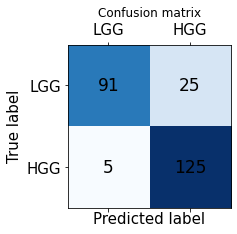

In [30]:
evaluate_model(model, test_lgg_hgg_generator.get_image_generator(batch_size), test_lgg_hgg_generator.get_seg_generator(batch_size))

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
LGG:  0.3975458 HGG: 0.6227847
Model performance:
              precision    recall  f1-score   support

         LGG       0.92      0.78      0.84       116
         HGG       0.82      0.94      0.88       130

    accuracy                           0.86       246
   macro avg       0.87      0.86      0.86       246
weighted avg       0.87      0.86      0.86       246



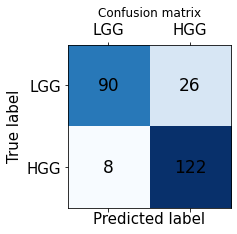

In [31]:
evaluate_model(model2, test_lgg_hgg_generator.get_image_generator(batch_size), test_lgg_hgg_generator.get_seg_generator(batch_size))

Found 246 images belonging to 2 classes.
Found 246 images belonging to 2 classes.
LGG:  0.4088694 HGG: 0.5991431
Model performance:
              precision    recall  f1-score   support

         LGG       0.95      0.78      0.86       116
         HGG       0.83      0.96      0.89       130

    accuracy                           0.88       246
   macro avg       0.89      0.87      0.88       246
weighted avg       0.89      0.88      0.88       246



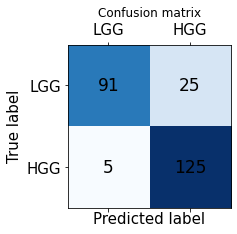

In [38]:
evaluate_model(model3, test_lgg_hgg_generator.get_image_generator(batch_size), test_lgg_hgg_generator.get_seg_generator(batch_size))

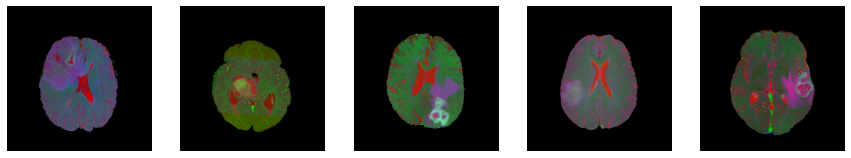

In [18]:
fig, axs = plt.subplots(1,5,figsize=(15, 20))
for x in range(5):
    visualization.plot_rgb(images[x], axs[x])

## Comparision of models

In [10]:
images, y = next(test_image_gen)
images_seg, y_seg = next(test_seg_gen)

In [32]:
model = load_model('../models/model-26-4_pen2.h5')
model2 = load_model('../models/model-26-4_org.h5')
model3 = load_model('../models/model-15-4_slicenet2.h5')

In [16]:
model = load_model('../models/model-18-4_pen1.h5')
model2 = load_model('../models/model-18-4_pen1.h5')
model3 = load_model('../models/model-18-4_pen2.h5')
model4 = load_model('../models/model-18-4_pen3.h5')
models = [model, model2, model3, model4]
analyzers = [innvestigate.create_analyzer("lrp.epsilon", m, epsilon=1) for m in models]

In [12]:
def postprocess_lrp(analyzed_image):
    analyzed_image = analyzed_image.sum(axis=np.argmax(np.asarray(analyzed_image.shape) == 3))
    analyzed_image /= np.max(np.abs(analyzed_image))
    return analyzed_image

In [13]:
def show_analysis(image, seg, y, model, analyzer):
    a = analyzer.analyze([image])['input_layer'][0]
    pred = model.predict(np.array([image])).argmax(axis=1)[0]
    mask_v = mask_value(a, image, get_mask_of_seg_rgb(seg))
    print("Mask Value: ", mask_v)
    print("Label: ", int(y), "Pred: ", pred)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes = axes.flatten()
    plot_lrp(postprocess_lrp(a), ax=axes[0], title = "{:.3f}".format(mask_v))
    plot_rgb(image, ax=axes[1])
    plot_gray(seg, ax=axes[2])

In [14]:
indx = 10
def show_analysis_all_models(image, seg, y, models, analyzers, labels = ["LGG", "HGG"]):
    fig, axes = plt.subplots(1, 6, figsize=(18, 3))
    axes = axes.flatten()
    plot_rgb(image, ax=axes[0], title = "label: {}".format(labels[int(y)]))
    plot_gray(seg, ax=axes[1])
    for i in range(4):
        a = analyzers[i].analyze([image])['input_layer'][0]
        pred = models[i].predict(np.array([image])).argmax(axis=1)[0]
        mask_v = mask_value(a, image, get_mask_of_seg_rgb(seg))
        plot_lrp(postprocess_lrp(a), ax=axes[i + 2], title = "{:.3f}, {}".format(mask_v, labels[pred]))

In [29]:
def evaluate_model(model, val_image_gen, val_seg_gen):
    m, p, y = get_mask_stat(val_image_gen, val_seg_gen, model)
    print("LGG: ", np.mean(m[y==0]), "HGG:", np.mean(m[y==1]))
    
    y_true_v = []
    pred_v = []
    iterations = val_image_gen.samples / batch_size
    for i, (images, labels) in enumerate(val_image_gen):
        prob = model.predict(images)
        p = prob.argmax(axis=1)
        pred_v.extend(p)
        y_true_v.extend(labels)
        if i + 1 > iterations:
            break
    plots.plot_model_performance(y_true_v, pred_v)